# fish species Classification

### Import all the Dependencies

In [7]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

### Set all the Constants

In [8]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "Fish_Dataset/Fish_Dataset"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE


## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 9000 files belonging to 9 classes.


### Checking the Available Classes

In [11]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

9 ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


### Displaying Some Sample Images

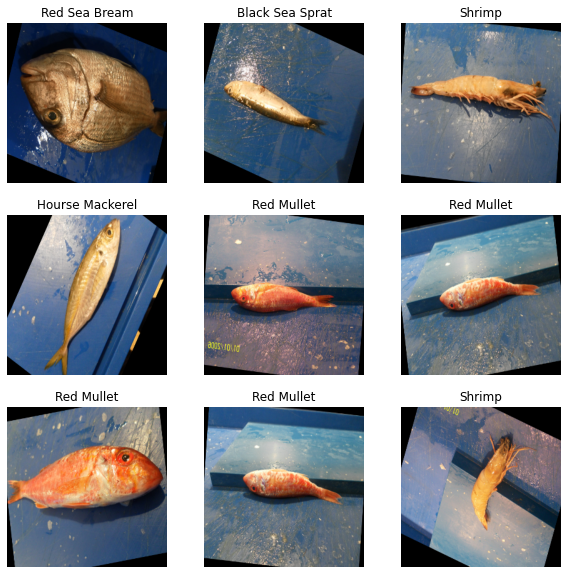

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Checking Batch Size

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


#### Checking what is the expected dimension order for channel

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Model Summary

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [25]:
history = model.fit(
    train_ds,
    batch_size=50,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)


Epoch 1/25
225/225 [==============================] - 850s 4s/step - loss: 1.1604 - accuracy: 0.5520 - val_loss: 0.8347 - val_accuracy: 0.6819
Epoch 2/25
225/225 [==============================] - 1790s 8s/step - loss: 0.6788 - accuracy: 0.7446 - val_loss: 0.4968 - val_accuracy: 0.8237
Epoch 3/25
225/225 [==============================] - 752s 3s/step - loss: 0.5300 - accuracy: 0.8021 - val_loss: 0.4021 - val_accuracy: 0.8516
Epoch 4/25
225/225 [==============================] - 840s 4s/step - loss: 0.4195 - accuracy: 0.8421 - val_loss: 0.2726 - val_accuracy: 0.9040
Epoch 5/25
225/225 [==============================] - 800s 4s/step - loss: 0.3601 - accuracy: 0.8616 - val_loss: 0.3554 - val_accuracy: 0.8504
Epoch 6/25
225/225 [==============================] - 908s 4s/step - loss: 0.3141 - accuracy: 0.8765 - val_loss: 0.2812 - val_accuracy: 0.8862
Epoch 7/25
225/225 [==============================] - 853s 4s/step - loss: 0.2570 - accuracy: 0.9040 - val_loss: 0.2941 - val_accuracy: 0.880

### Testing the Model

In [27]:
model.save("caubey.h5")

In [28]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
29/29 [==============================] - 96s 894ms/step - loss: 0.0470 - accuracy: 0.9860
Test Accuracy: 98.6%


## Create a Quantization Aware Model
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

### Quantize only the Dense, MaxPool2D, Conv2D Layers

In [29]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer



### Clone the Model and Make Quantization Aware 

In [30]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 32)     963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 127, 127, 32)     1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 125, 125, 64)     18627     
 pperV2)                                                         
                                                      

### Compile Quantization Aware Model before Fine Tuning

In [31]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Fine Tuning the Quantization Aware Model

In [33]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)


Epoch 1/3
225/225 [==============================] - 1599s 7s/step - loss: 0.0941 - accuracy: 0.9707 - val_loss: 0.0294 - val_accuracy: 0.9888
Epoch 2/3
225/225 [==============================] - 1696s 8s/step - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0338 - val_accuracy: 0.9855
Epoch 3/3
225/225 [==============================] - 1550s 7s/step - loss: 0.0662 - accuracy: 0.9816 - val_loss: 0.0876 - val_accuracy: 0.9654


### Evaluate the Model Accuracy

In [34]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
29/29 [==============================] - 189s 7s/step - loss: 0.0815 - accuracy: 0.9709
Test Accuracy: 97.09%


## Convert Quanitzation Aware Model to TF Lite Model

### Convert the Model

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\OFFICE\AppData\Local\Temp\tmpzxse_3nf\assets


INFO:tensorflow:Assets written to: C:\Users\OFFICE\AppData\Local\Temp\tmpzxse_3nf\assets
C:\Users\OFFICE\anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Evaluate the TF Lite Model

### Saving the TF Lite Model
We append the model to the list of models as a new version

### Plotting the Inference Data

In [47]:
test=get_img_array("00006.png",(256,256,3))

pred=model.predict(test)
pred=np.argmax(pred,axis=1)
pred

1/1 [==============================] - 0s 49ms/step


array([3], dtype=int64)

In [40]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array